In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
from sklearn.model_selection import GridSearchCV

In [ ]:
tickers=["ITC","INFY", "LT.NS","RELIANCE.NS","COALINDIA.NS","MARUTI.NS","NTPC.NS","TCS.NS","TITAN.NS","BRITANNIA.NS","ONGC.NS","CIPLA.NS","WIPRO.NS"]

In [ ]:
all_data = pd.DataFrame()
test_data = pd.DataFrame()
no_data = []

#Extract data from Yahoo Finance
for i in tickers:
    try:
        test_data = pdr.get_data_yahoo(i, start = dt.datetime(1990,1,1), end = dt.date.today())
        test_data['symbol'] = i
        all_data = all_data.append(test_data)
        clear_output(wait = True)
        print(i)
    except:
        no_data.append(i)

    clear_output(wait = True)

WIPRO.NS


In [ ]:
print(no_data)

[]


In [ ]:
all_data['SMA_5'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 5).mean())
all_data['SMA_15'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 15).mean())
all_data['SMA_ratio'] = all_data['SMA_15'] / all_data['SMA_5']

all_data['SMA5_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 5).mean())
all_data['SMA15_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 15).mean())
all_data['SMA_Volume_Ratio'] = all_data['SMA5_Volume']/all_data['SMA15_Volume']

In [ ]:
all_data['Lowest_5D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 5).min())
all_data['High_5D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 5).max())
all_data['Lowest_15D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 15).min())
all_data['High_15D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 15).max())

all_data['Stochastic_5'] = ((all_data['Close'] - all_data['Lowest_5D'])/(all_data['High_5D'] - all_data['Lowest_5D']))*100
all_data['Stochastic_15'] = ((all_data['Close'] - all_data['Lowest_15D'])/(all_data['High_15D'] - all_data['Lowest_15D']))*100

all_data['Stochastic_%D_5'] = all_data['Stochastic_5'].rolling(window = 5).mean()
all_data['Stochastic_%D_15'] = all_data['Stochastic_5'].rolling(window = 15).mean()

all_data['Stochastic_Ratio'] = all_data['Stochastic_%D_5']/all_data['Stochastic_%D_15']


In [ ]:
all_data['Diff'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.diff())
all_data['Up'] = all_data['Diff']
all_data.loc[(all_data['Up']<0), 'Up'] = 0

all_data['Down'] = all_data['Diff']
all_data.loc[(all_data['Down']>0), 'Down'] = 0 
all_data['Down'] = abs(all_data['Down'])

all_data['avg_5up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=5).mean())
all_data['avg_5down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=5).mean())

all_data['avg_15up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=15).mean())
all_data['avg_15down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=15).mean())

all_data['RS_5'] = all_data['avg_5up'] / all_data['avg_5down']
all_data['RS_15'] = all_data['avg_15up'] / all_data['avg_15down']

all_data['RSI_5'] = 100 - (100/(1+all_data['RS_5']))
all_data['RSI_15'] = 100 - (100/(1+all_data['RS_15']))

all_data['RSI_ratio'] = all_data['RSI_5']/all_data['RSI_15']


In [ ]:
all_data['5Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
all_data['15Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
all_data['MACD'] = all_data['15Ewm'] - all_data['5Ewm']

all_data['15MA'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).mean())
all_data['SD'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).std())
all_data['upperband'] = all_data['15MA'] + 2*all_data['SD']
all_data['lowerband'] = all_data['15MA'] - 2*all_data['SD']

all_data['RC'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.pct_change(periods = 15)) 


In [ ]:
Target_variables = ['SMA_ratio','SMA_Volume_Ratio','Stochastic_5','Stochastic_15','Stochastic_Ratio','RSI_5','RSI_15','RSI_ratio','MACD']
for variable in Target_variables:
    all_data.loc[:,variable] = mstats.winsorize(all_data.loc[:,variable], limits = [0.1,0.1])

In [ ]:
#Extract the returns
all_data['return'] = all_data['Close'].pct_change()
returns = all_data[['symbol','return']].copy()
returns['Date'] = returns.index.copy()

In [ ]:
# Data Formatting
transposed = returns.pivot(index = 'Date', columns = 'symbol', values = 'return')
X = transposed.dropna().transpose()


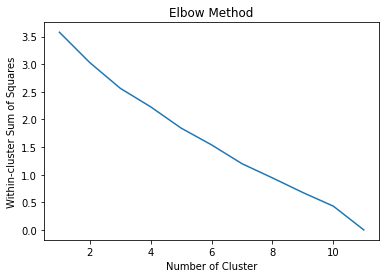

In [ ]:
# K Means Clustering
sum_of_sq = np.zeros([12, 1])
sum_of_sq = np.zeros([12, 1])
for k in range(1, 12):
    sum_of_sq[k-1] = KMeans(n_clusters=k).fit(X).inertia_
    
plt.plot(range(1, 12), sum_of_sq[1:12])
plt.title("Elbow Method") 
plt.xlabel("Number of Cluster") 
plt.ylabel("Within-cluster Sum of Squares")
plt.show()

In [ ]:
# Gaussian Mixture Model
gmm = GaussianMixture(n_components = 5)
gmm.fit(transposed.dropna().transpose())
clusters = gmm.predict(transposed.dropna().transpose())
clusters_df = pd.DataFrame({'Cluster':clusters,'Companies':transposed.columns})
clusters_df = clusters_df.sort_values(['Cluster']).reset_index(drop = True)
print (clusters_df)

clusters_df.to_csv("clusters.csv")

    Cluster     Companies
0         0          INFY
1         0        TCS.NS
2         0      WIPRO.NS
3         1           ITC
4         2      CIPLA.NS
5         2  COALINDIA.NS
6         2       NTPC.NS
7         2       ONGC.NS
8         3  BRITANNIA.NS
9         3         LT.NS
10        3     MARUTI.NS
11        3   RELIANCE.NS
12        4      TITAN.NS


In [ ]:
# Calculating target direction

all_data['Close_Shifted'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.shift(-6))
all_data['Target'] = ((all_data['Close_Shifted'] - all_data['Open'])/(all_data['Open']) * 100).shift(-1)
all_data['Target_Direction'] = np.where(all_data['Target']>0,1,0)
all_data = all_data.dropna().copy()

In [ ]:
# Splitting Data into test and train based on the time stamp

all_data.index = pd.to_datetime(all_data.index)

train_data = all_data.loc['2006-01-01':'2016-12-31',]
test_data = all_data.loc['2017-01-01':'2019-12-31'] 

In [ ]:
# Training data and labels

X_train = train_data.loc[:,Target_variables]

Y_train = train_data.loc[:,['Target_Direction']]

In [ ]:
X_train=np.array(X_train)
Y_train=np.squeeze(Y_train)

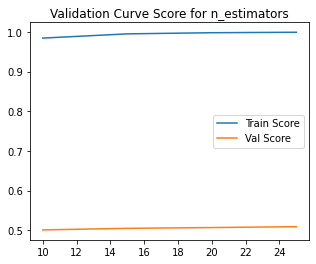

In [ ]:
# Creating Random Classifier

rf = RandomForestClassifier()
train_scoreNum, val_scoreNum = validation_curve(rf,
                                X = X_train, y = Y_train, 
                                param_name = 'n_estimators',
                                param_range = [10,15,20,25], cv = TimeSeriesSplit(n_splits = 3))

train_scores_mean = np.mean(train_scoreNum, axis=1)
train_scores_std = np.std(train_scoreNum, axis=1)
val_scores_mean = np.mean(val_scoreNum, axis=1)
val_scores_std = np.std(val_scoreNum, axis=1)

plt.figure(figsize = (5,4))
plt.plot([10,15,20,25],train_scores_mean)
plt.plot([10,15,20,25],val_scores_mean)
plt.legend(['Train Score','Val Score'])
plt.title('Validation Curve Score for n_estimators')
plt.show()

The current cluster running is : 0


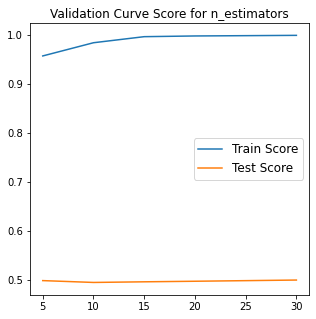

The current cluster running is : 1


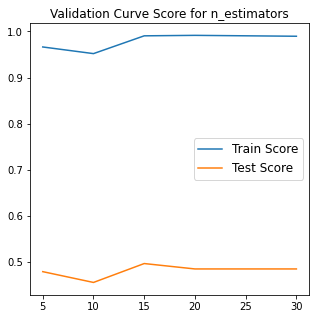

The current cluster running is : 2


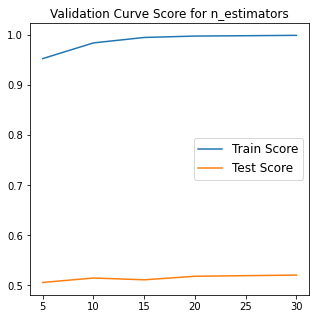

The current cluster running is : 3


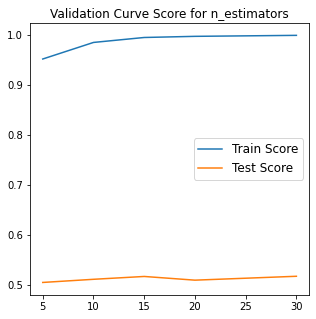

The current cluster running is : 4


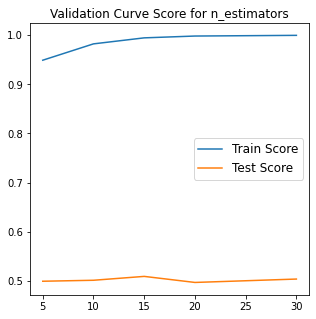

In [ ]:
# Generating RF Classifiers using the GMM clusters 

# Cluster data loop

for cluster_selected in clusters_df.Cluster.unique():
    print(f'The current cluster running is : {cluster_selected}')
    
    #Get data for that cluster
    cluster_data = all_data[all_data.symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
    X_train = cluster_data.loc['2006-01-01':'2016-12-31',Target_variables].copy()
    X_train = X_train.dropna()
    Y_train = cluster_data.loc['2006-01-01':'2016-12-31',['Target_Direction']]
    X_train = np.array(X_train)
    Y_train = np.squeeze(Y_train)    
    # Creating Random Classifier

    rf = RandomForestClassifier()
    train_scoreNum, val_scoreNum = validation_curve(rf,
                                X = X_train, y = Y_train, 
                                param_name = 'n_estimators', 
                                param_range = [5,10,15,20,30], cv = TimeSeriesSplit(n_splits = 3))

    train_scores_mean = np.mean(train_scoreNum, axis=1)
    train_scores_std = np.std(train_scoreNum, axis=1)
    val_scores_mean = np.mean(val_scoreNum, axis=1)
    val_scores_std = np.std(val_scoreNum, axis=1)

    plt.figure(figsize = (5,5))
    plt.plot([5,10,15,20,30],train_scores_mean)
    plt.plot([5,10,15,20,30],val_scores_mean)
    plt.legend(['Train Score','Val Score'], fontsize = 'large')
    plt.title('Validation Curve Score for n_estimators', fontsize = 'large')
    plt.show()
